<a href="https://colab.research.google.com/github/paulnord/ExampleCode/blob/main/LSTM_fitting_chirp_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LSTM Fitting with simulated chirp data.  


In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Parameters for the dataset
num_samples = 10000  # Total number of samples
sequence_length = 1024  # Length of each chirp waveform
f0_range = (10, 50)  # Initial frequency range (Hz)
fc_range = (60, 200)  # Final frequency range (Hz)
amplitude_range = (0.5, 2.0)  # Amplitude growth factor range
noise_level = 2.2  # Standard deviation of Gaussian noise
phase_shift_range = (0, 2 * np.pi)  # Phase shift range for sine wave

# Dataset split ratios
train_ratio = 0.7
validation_ratio = 0.2
test_ratio = 0.1


# Calculate dataset sizes
num_train = int(num_samples * train_ratio)
num_validation = int(num_samples * validation_ratio)
num_test = num_samples - num_train - num_validation

def generate_chirp_data(num_samples):
    inputs = []
    outputs = []

    for _ in range(num_samples):
        # Randomly sample parameters
        f0 = np.random.uniform(*f0_range)
        fc = np.random.uniform(*fc_range)
        A = np.random.uniform(*amplitude_range)
        phase_shift = np.random.uniform(*phase_shift_range)

        # Time array
        T = 1.0  # Total duration (seconds)
        t = np.linspace(0, T, sequence_length)

        # Frequency as a function of time
        k = (fc - f0) / T  # Frequency growth rate
        f_t = f0 + k * t**2  # Quadratic frequency growth

        # Phase integration (integral of frequency over time)
        phi_t = 2 * np.pi * np.cumsum(f_t) * (t[1] - t[0])  # Numerical integration

        # Chirp waveform
        h_t = A * t**0.5 * np.sin(phi_t+phase_shift)

        # Add Gaussian noise
        h_t_noisy = h_t + np.random.normal(0, noise_level, size=sequence_length)

        # Append data
        inputs.append(h_t_noisy.tolist())  # Convert to list for proper CSV serialization
        outputs.append([f0, fc, A])

    return inputs, np.array(outputs)

# Generate datasets
train_inputs, train_outputs = generate_chirp_data(num_train)
validation_inputs, validation_outputs = generate_chirp_data(num_validation)
test_inputs, test_outputs = generate_chirp_data(num_test)

# Normalize Outputs
output_scaler = MinMaxScaler(feature_range=(0, 1))
train_outputs = output_scaler.fit_transform(train_outputs)
validation_outputs = output_scaler.transform(validation_outputs)
test_outputs = output_scaler.transform(test_outputs)

# Save to CSV files
def save_to_csv(inputs, outputs, file_name):
    data = pd.DataFrame({
        'inputs': [','.join(map(str, input_row)) for input_row in inputs],  # Properly format inputs with commas
        'f0': outputs[:, 0],
        'fc': outputs[:, 1],
        'amplitude': outputs[:, 2],
    })
    data.to_csv(file_name, index=False)

save_to_csv(train_inputs, train_outputs, "chirp_train_data.csv")
save_to_csv(validation_inputs, validation_outputs, "chirp_validation_data.csv")
save_to_csv(test_inputs, test_outputs, "chirp_test_data.csv")

"Chirp dataset created: chirp_train_data.csv, chirp_validation_data.csv, chirp_test_data.csv"


'Chirp dataset created: chirp_train_data.csv, chirp_validation_data.csv, chirp_test_data.csv'

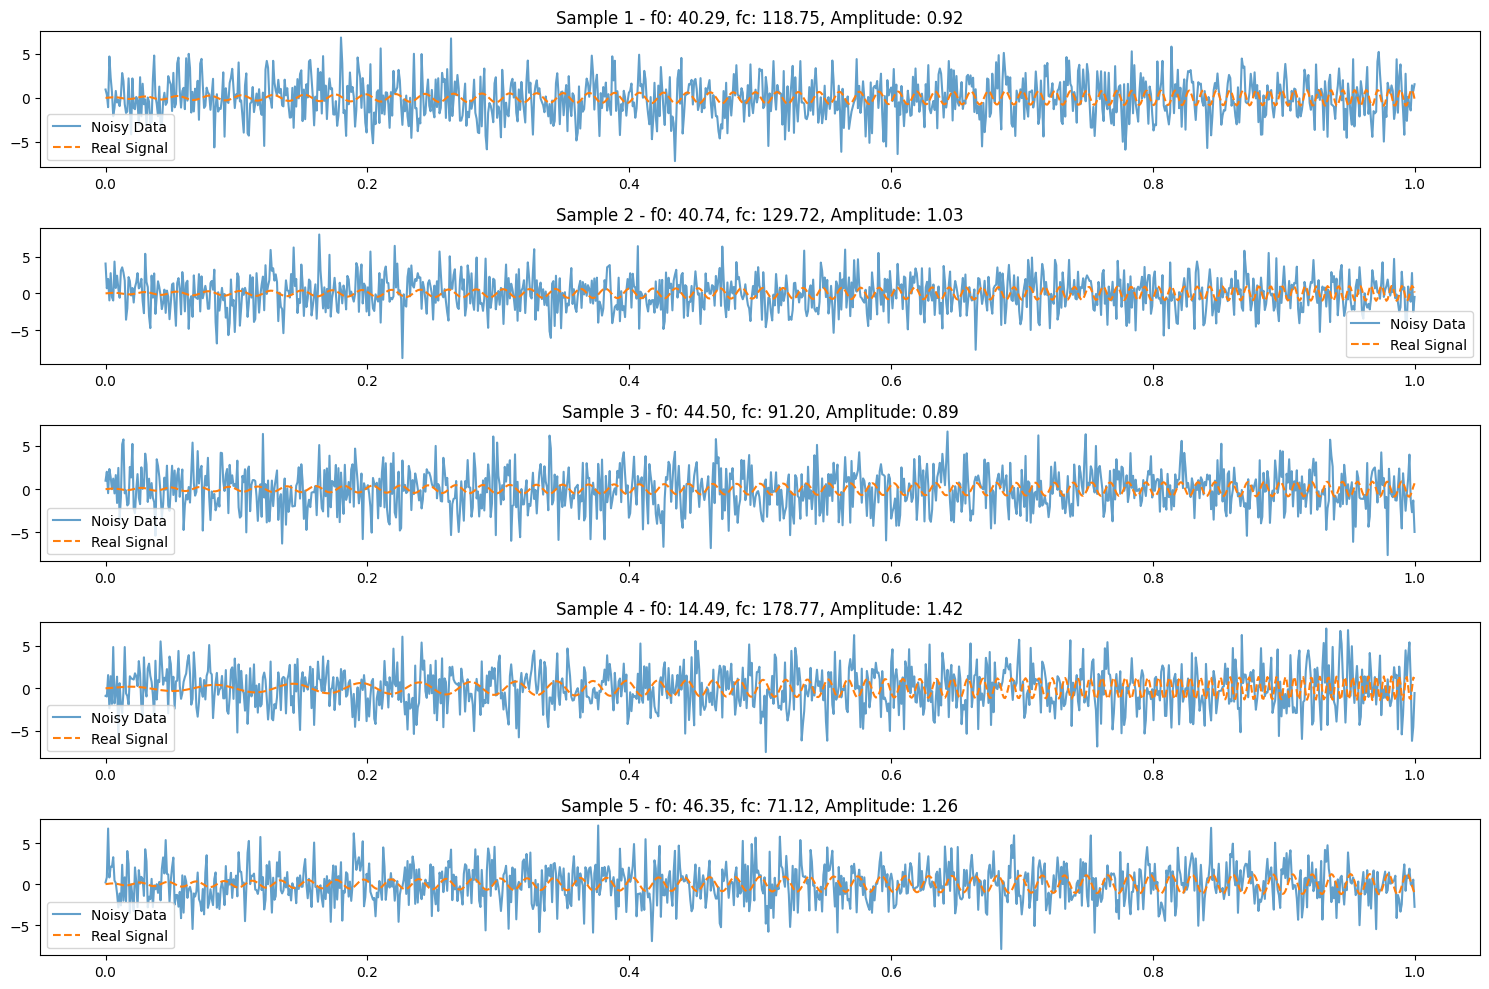

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to load data
def load_data(file_name):
    """
    Load chirp waveform data from a CSV file.
    """
    data = pd.read_csv(file_name)

    # Parse inputs into a 2D NumPy array
    inputs = np.array(
        [np.array(eval(row)) if isinstance(row, str) else row for row in data["inputs"]]
    )

    # Extract outputs as a NumPy array
    outputs = data[["f0", "fc", "amplitude"]].values
    return inputs, outputs

# Function to reverse normalization
def inverse_normalize(normalized_values, min_val, max_val):
    """
    Reverses the normalization of a value scaled between [0, 1].

    Parameters:
    - normalized_values: The normalized value(s) (array or single value).
    - min_val: Minimum value of the original range.
    - max_val: Maximum value of the original range.

    Returns:
    - Original values rescaled to the given range.
    """
    return normalized_values * (max_val - min_val) + min_val

# Visualization function
def visualize_chirp_data(file_name, f0_range, fc_range, amplitude_range, num_samples_to_plot=5):
    """
    Visualize noisy and real chirp waveforms.

    Parameters:
    - file_name: Path to the CSV file containing chirp data.
    - f0_range: Tuple (min, max) for initial frequency.
    - fc_range: Tuple (min, max) for final frequency.
    - amplitude_range: Tuple (min, max) for amplitude.
    - num_samples_to_plot: Number of samples to plot.
    """
    # Load the data
    inputs, outputs = load_data(file_name)

    # Plot
    plt.figure(figsize=(15, 10))
    for i in range(num_samples_to_plot):
        noisy_data = inputs[i]
        f0, fc, amplitude = outputs[i]  # These are normalized values

        # Reverse normalization
        f0 = inverse_normalize(f0, *f0_range)
        fc = inverse_normalize(fc, *fc_range)
        amplitude = inverse_normalize(amplitude, *amplitude_range)

        # Generate the "true" chirp signal for comparison
        t = np.linspace(0, 1, len(noisy_data))
        k = (fc - f0) / 1.0  # Growth rate for frequency
        f_t = f0 + k * t**2
        phi_t = 2 * np.pi * np.cumsum(f_t) * (t[1] - t[0])  # Phase integration
        real_signal = amplitude * t**0.5 * np.sin(phi_t)

        plt.subplot(num_samples_to_plot, 1, i + 1)
        plt.plot(t, noisy_data, label="Noisy Data", alpha=0.7)
        plt.plot(t, real_signal, label="Real Signal", linestyle="--")
        plt.title(f"Sample {i + 1} - f0: {f0:.2f}, fc: {fc:.2f}, Amplitude: {amplitude:.2f}")
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
chirp_file = "chirp_train_data.csv"
f0_range = (10, 50)  # Initial frequency range (Hz)
fc_range = (60, 200)  # Final frequency range (Hz)
amplitude_range = (0.5, 2.0)  # Amplitude range

visualize_chirp_data(chirp_file, f0_range, fc_range, amplitude_range, num_samples_to_plot=5)


Is GPU available?  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 1020, 64)            │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 510, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 510, 256)            │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 510, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 510, 256)            │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 510, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,085,571 (4.14 MB)

 Trainable params: 1,085,571 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

None


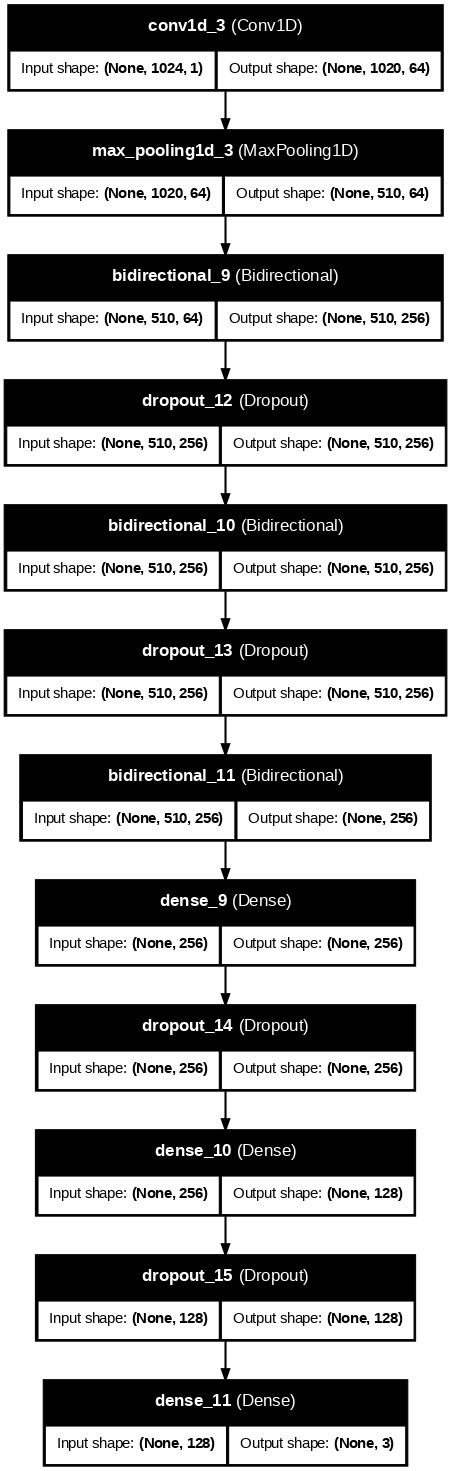

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 180ms/step - loss: 0.1320 - mae: 0.2954 - val_loss: 0.0856 - val_mae: 0.2459
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - loss: 0.0829 - mae: 0.2391 - val_loss: 0.0712 - val_mae: 0.2243
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - loss: 0.0768 - mae: 0.2300 - val_loss: 0.0577 - val_mae: 0.1972
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - loss: 0.0638 - mae: 0.2067 - val_loss: 0.0695 - val_mae: 0.2198
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 179ms/step - loss: 0.0678 - mae: 0.2153 - val_loss: 0.0523 - val_mae: 0.1853
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - loss: 0.0576 - mae: 0.1951 - val_loss: 0.0504 - val_mae: 0.1816
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - loss: 0.0551 - mae: 0.1892 - val_loss: 0.0556 - val_mae: 0.1920
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - loss: 0.0547 - mae: 0.1885 - val_loss: 0.0526 - val_mae: 0.1824
Epoch 9/100
110/110 ━━━━

In [20]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
from tensorflow.config import list_physical_devices

# Check if GPU is available
gpu_available = list_physical_devices('GPU')
print("Is GPU available? ", gpu_available)

# Helper function to load data
def load_data(file_name, input_col="inputs", output_cols=None):
    """
    Loads data from a CSV file and extracts inputs and outputs.

    Parameters:
    - file_name: Path to the CSV file.
    - input_col: Name of the column containing input sequences.
    - output_cols: List of column names for outputs.

    Returns:
    - inputs: NumPy array of input sequences.
    - outputs: NumPy array of output parameters.
    """
    data = pd.read_csv(file_name)

    # Parse inputs into a 2D NumPy array
    inputs = np.array(
        [np.array(eval(row)) if isinstance(row, str) else row for row in data[input_col]]
    )

    # Extract outputs if specified
    if output_cols:
        outputs = data[output_cols].values
    else:
        outputs = None

    return inputs, outputs


# Model definition function
def create_model(input_shape, output_dim):
    """
    Builds and returns the neural network model.

    Parameters:
    - input_shape: Tuple specifying the input shape (time_steps, features).
    - output_dim: Number of outputs (e.g., 3 for frequency, amplitude, phase shift).

    Returns:
    - model: Compiled Keras model.
    """
    model = Sequential()

    # Convolutional layer to extract local features
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))  # Downsample the sequence

    # Stacked Bidirectional LSTM layers
    model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True)))
    model.add(Dropout(0.3))  # Dropout for regularization
    model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(128, activation='tanh')))

    # Dense layers for prediction
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim))  # Output layer

    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])
    return model


# Training function
def train_model(model, train_inputs, train_outputs, validation_inputs, validation_outputs, epochs=100, batch_size=64):
    """
    Trains the given model on the provided data.

    Parameters:
    - model: The Keras model to train.
    - train_inputs: Training input data.
    - train_outputs: Training output data.
    - validation_inputs: Validation input data.
    - validation_outputs: Validation output data.
    - epochs: Number of training epochs.
    - batch_size: Batch size for training.

    Returns:
    - history: Training history object.
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        train_inputs, train_outputs,
        validation_data=(validation_inputs, validation_outputs),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping]
    )
    return history


# File prefixes and column names
file_prefix = "chirp_"
input_col = "inputs"
output_cols = ["f0", "fc", "amplitude"]

# File paths
train_file = file_prefix + "train_data.csv"
validation_file = file_prefix + "validation_data.csv"
test_file = file_prefix + "test_data.csv"

# Load data
train_inputs, train_outputs = load_data(train_file, input_col, output_cols)
validation_inputs, validation_outputs = load_data(validation_file, input_col, output_cols)
test_inputs, test_outputs = load_data(test_file, input_col, output_cols)

# Reshape inputs for LSTM
train_inputs = train_inputs.reshape(train_inputs.shape[0], train_inputs.shape[1], 1)
validation_inputs = validation_inputs.reshape(validation_inputs.shape[0], validation_inputs.shape[1], 1)
test_inputs = test_inputs.reshape(test_inputs.shape[0], test_inputs.shape[1], 1)

# Create and train the model
model = create_model(input_shape=(train_inputs.shape[1], 1), output_dim=len(output_cols))
print(model.summary())

# Save and display model architecture
plot_file = "model_diagram.png"
plot_model(model, to_file=plot_file, show_shapes=True, show_layer_names=True, dpi=75)
display(Image(plot_file))

# Train the model
history = train_model(
    model, train_inputs, train_outputs, validation_inputs, validation_outputs
)

# Evaluate on test set
test_loss, test_mae = model.evaluate(test_inputs, test_outputs)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Save predictions for analysis
predictions = model.predict(test_inputs)
predictions_df = pd.DataFrame(predictions, columns=[f"predicted_{col}" for col in output_cols])
actuals_df = pd.DataFrame(test_outputs, columns=[f"actual_{col}" for col in output_cols])
comparison_df = pd.concat([predictions_df, actuals_df], axis=1)
comparison_df.to_csv("predictions_vs_actuals.csv", index=False)
print("Predictions vs Actuals saved to predictions_vs_actuals.csv")

# Save the trained model
model.save("trained_model.keras")
print("Trained model saved to 'trained_model.keras'")


Sample of the data:
   predicted_f0  predicted_fc  predicted_amplitude  actual_f0  actual_fc  \
0      0.806010      0.399155             0.766944   0.788047   0.418740   
1      0.516034      0.108459             0.628115   0.522463   0.044883   
2      0.137224      0.150422             0.771494   0.000974   0.137309   
3      0.323048      0.105093             0.821109   0.256807   0.034874   
4      0.090905      0.386502             0.784671   0.013958   0.411314   

   actual_amplitude  
0          0.709129  
1          0.490508  
2          0.822449  
3          0.889647  
4          0.885530  


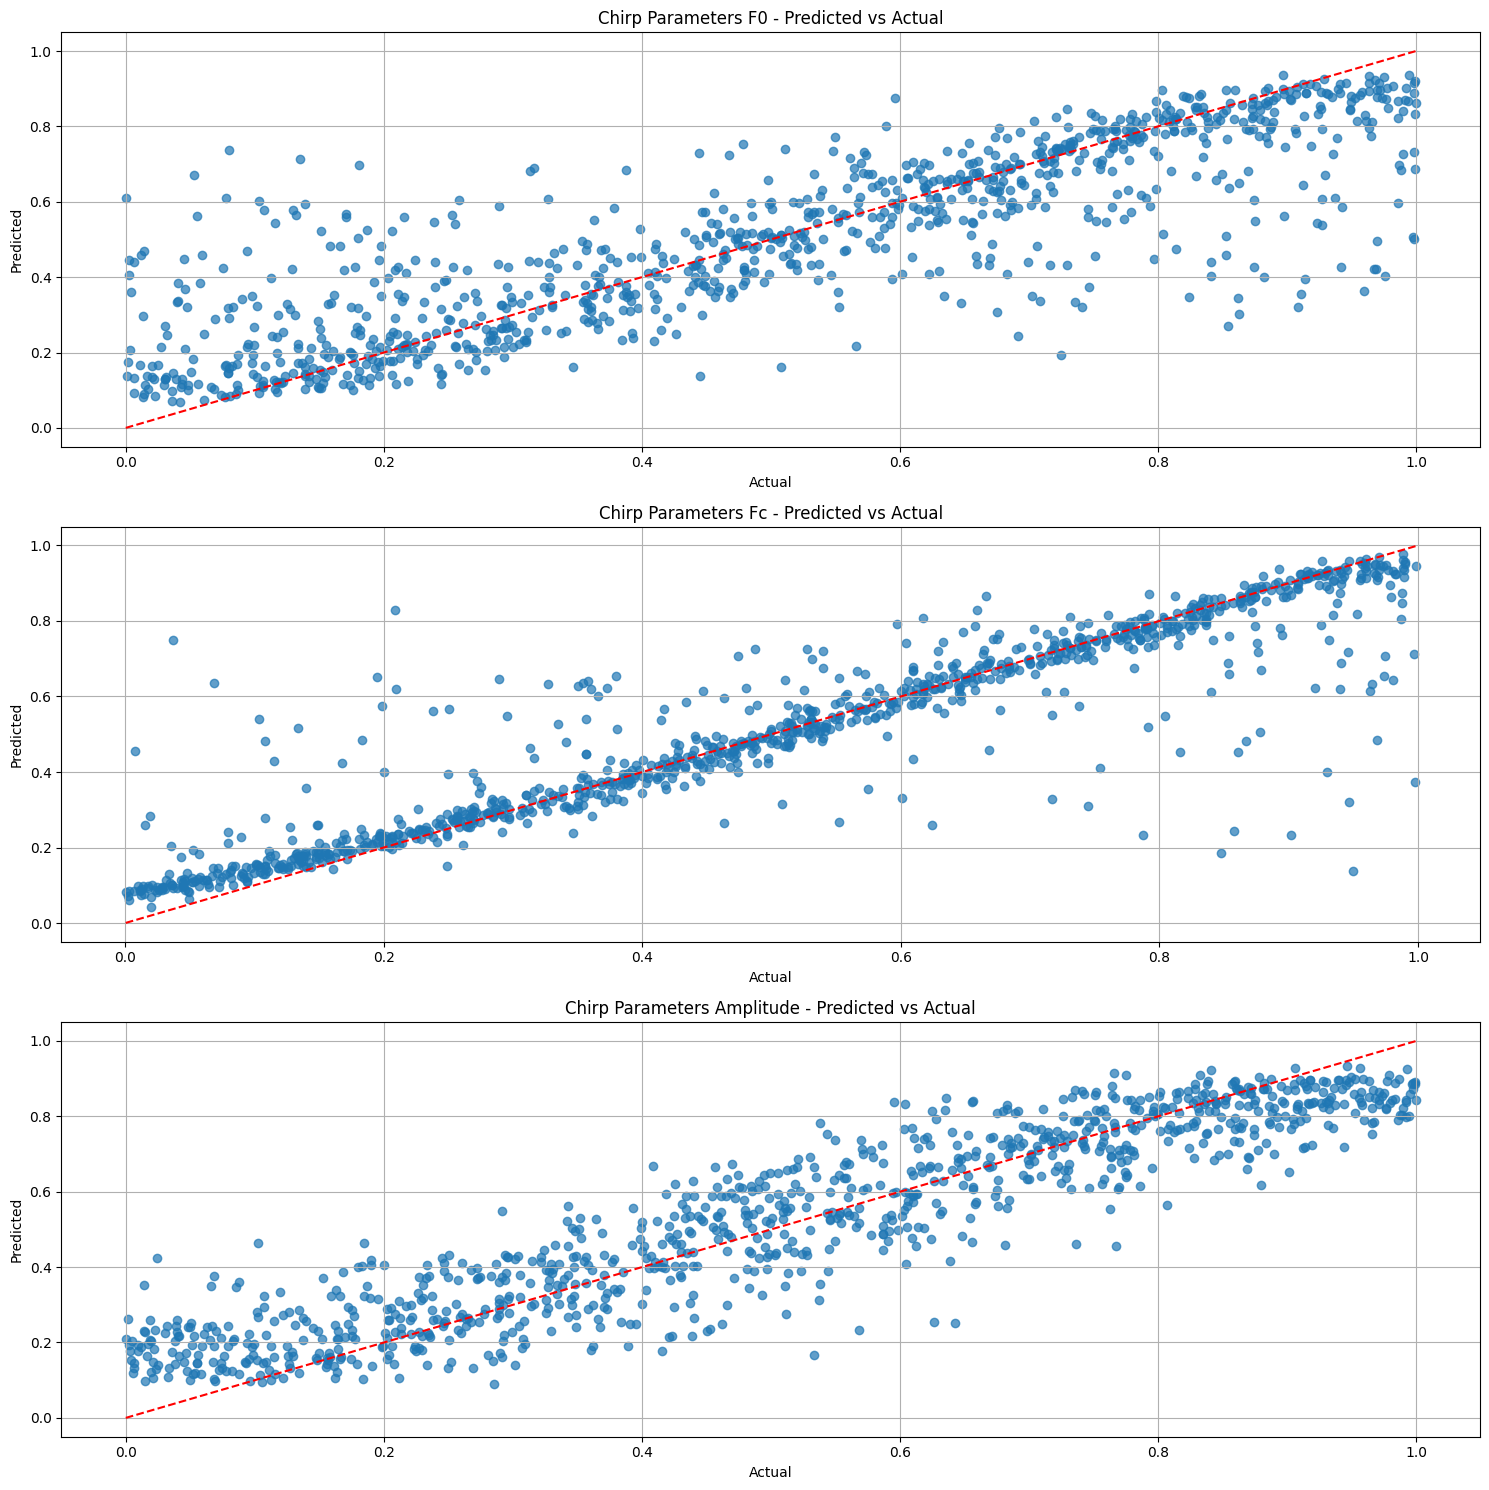

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_predictions_vs_actuals(
    predictions_file, predicted_columns, actual_columns, title_prefix="Parameter"
):
    """
    Plots the predicted vs actual correlations for a model.

    Parameters:
    - predictions_file: Path to the CSV file containing predictions and actuals.
    - predicted_columns: List of column names for predicted values.
    - actual_columns: List of column names for actual values.
    - title_prefix: Prefix for plot titles (default: "Parameter").
    """
    # Load the predictions vs actuals data
    data = pd.read_csv(predictions_file)

    # Display the predictions vs actuals data
    print("Sample of the data:")
    print(data.head())

    # Plot each correlation
    plt.figure(figsize=(15, 5 * len(predicted_columns)))  # Adjust height based on number of plots

    for i, (predicted, actual) in enumerate(zip(predicted_columns, actual_columns)):
        plt.subplot(len(predicted_columns), 1, i + 1)
        plt.scatter(data[actual], data[predicted], alpha=0.7)
        plt.plot(
            [data[actual].min(), data[actual].max()],
            [data[actual].min(), data[actual].max()],
            color='red', linestyle='--'
        )
        plt.title(f"{title_prefix} {actual.split('_')[1].capitalize()} - Predicted vs Actual")
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
predictions_file = "predictions_vs_actuals.csv"
# Updated column names for f0, fc, and amplitude
predicted_columns = ["predicted_f0", "predicted_fc", "predicted_amplitude"]
actual_columns = ["actual_f0", "actual_fc", "actual_amplitude"]

# Call the generalized plotting function
plot_predictions_vs_actuals(
    predictions_file,
    predicted_columns,
    actual_columns,
    title_prefix="Chirp Parameters"
)